# Monte Carlo Integration

Monte Carlo integration provides us with a method that has a convergence rate independent of the dimensionality of the integrand. This is great news because the error from deterministic methods always ends up getting exponentially slower with the dimension of our problem. As such Monte Carlo integration is the weapon of choice whenever we have more than a handful of dimensions.

This notebook aims at introducing Monte Carlo methods with a simple implementation of two very common algorithms: vanilla MC and the MISER algorithm.

**NOTE** Although both of the implementation work, they always take the route of being more easy to understand and didactic when it is needed. As such they are not meant to be used in any sort of production environment.

## Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt

## Test Integrands

In [685]:
exact_integral = 0.5
exact_variance = (3/8.) - 0.5**2

def f(x):
    y = np.cos(np.pi * x)**4
    return y

def g(x):
    return np.cos(np.pi*4*x[0] + 0.01)*x[1]

def h(x):
    return ((x[0]**2 + x[1]**2) < 0.9**2).astype("float") - 
         \ ((x[0]**2 + x[1]**2) < 0.3**2).astype("float")

## Utitlity functions

In [ ]:
def running_average(x):
    # We upgrade 1D arrays to matrices so that the code
    # after also works on them.
    x = np.atleast_2d(x)
    
    running_avg = np.cumsum(x, axis=1) / (np.arange(x.shape[1]) + 1)[ None, :]
    
    return running_avg

def guess_dims(f):
    dim = 1
    
    while True:
        try:
            f(np.random.rand(dim))
            return dim
        except IndexError:
            dim += 1
            continue

## Vanilla Monte Carlo

In [529]:
def MonteCarloIntegral(f, N, fractional_error_tolerance=0.1, dim=None):
    if dim == None:
        dim = guess_dims(f)
        
    relative_error = 1.
    function_evaluations = list()
    while relative_error > fractional_error_tolerance:
        for _ in range(int(N)):
            F = f(np.random.rand(dim))
            function_evaluations.append(F)

        integral_estimate = np.mean(function_evaluations)
        variance_estimate = np.mean((np.array(function_evaluations) - integral_estimate)**2)
        error_estimate = np.sqrt(variance_estimate / len(function_evaluations))

        relative_error = error_estimate / integral_estimate

        
        # Calculate an estimate of how many extra points we would need
        # to reach our target relative error.
        #
        # var/N = (err)**2 and var/N_new = (new_err)**2 so:
        # N_new = (err/new_err)**2 * N
        # but we've already done N so next iteration requires: 
        # N * ((err/new_err)**2 - 1)
        # plus 1 to avoid case were we get stuck into an inf loop because N=0
        N = len(function_evaluations) * ((relative_error / fractional_error_tolerance)**2 - 1) + 1
    
    print("Total evaluations:", len(function_evaluations))
    
    return (integral_estimate, variance_estimate, error_estimate)


In [477]:
N = 3000
MonteCarloIntegral(g, N, 0.01)

Total evaluations: 53351


(0.07811207828320813, 0.03253637477638979, 0.0007809321433930031)

In [431]:
N = 1000
function_evaluations = f(np.random.rand(100, N))
# function_evaluations = g(np.random.rand(guess_dims(g), 100, N))

In [433]:
error_distribution_estimate = np.std(running_average(function_evaluations), axis=0)
integral_estimate = np.mean(function_evaluations)
variance_estimate = np.mean((np.array(function_evaluations) - integral_estimate)**2)

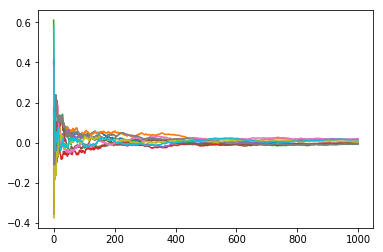

In [434]:
x = np.linspace(1, N, N)
plt.plot((running_average(function_evaluations) - integral_estimate)[::10].T);

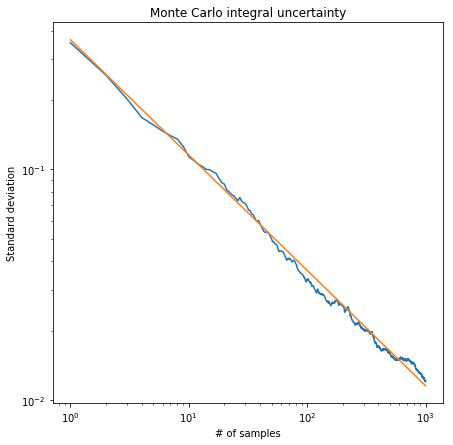

In [736]:
fig, ax = plt.subplots(figsize=(7, 7))


ax.set_xlabel("# of samples")
ax.set_ylabel("Standard deviation")
ax.set_title("Monte Carlo integral uncertainty")

ax.loglog(x, error_distribution_estimate)
ax.loglog(x, np.sqrt(variance_estimate)/np.sqrt(x));

# MISER

In [729]:
from numpy.random import uniform

class MISER:
    def __init__(self, miser_params):
        """
        Parameters
        ----------
        MNBS : int
            If less than MNBS evaluations are left we do
            vanilla MC.
        MNPTS : int
            Minimum number of points used for variance
            exploration.
        pfac : float in [0,1]
            Fraction of the remaining points used in each
            recursive call. Typical value is 0.1
        alpha : float
            Factor used to estimate the optimal points to be
            used on each side of a bisection. Usually set to 2
        """
        self.MNBS = miser_params["MNBS"]
        self.MNPTS = miser_params["MNPTS"]
        self.pfac = miser_params["pfac"]
        self.alpha = miser_params["alpha"]
        
    def miser_kernel(self, f, N_points, xl, xu):
        """
        MISER algorithm.
        
        Parameters
        ----------
        f : function
            The integrand, it needs to be vectorized.
        N_points : int
            Total number of function evaluations available.
        xl : [float]
            List of lower bounds of the integral.
        xu : [float]
            List of upper bounds of the integral.
        
        Returns
        -------
        ave : float
            Estimate of the integral.
        var : float
            Estimated variance of the integral.
        """
        ndims = len(xu)

        if N_points < self.MNBS: # Straight Monte Carlo
            ave, var = self._mc_kernel(f, xu, xl, N_points)
            
            return ave, var
            
        else: # Recursion path
            # 1) Calculate number of points for this
            #    variance exploration step
            npre = int(max(self.pfac * N_points, self.MNPTS))
            
            # 2) Find best split         
            newxu, newxl, var_l, var_u = self._split_domain(f, xl, xu, npre)

            # 3) Compute new allocation of points for split regions
            N_points_remaining = N_points - npre
            N_points_l, N_points_u = self._allocate_points(var_l, var_u, N_points_remaining)

            # 4) Recurse
            ave_l, var_l = self.miser_kernel(f, N_points_l, xl, newxu)
            ave_u, var_u = self.miser_kernel(f, N_points_u, newxl, xu)
            
            # 5) Combine results
            ave = 0.5 * (ave_l + ave_u)
            var = 0.25 * (var_l + var_u)

            return (ave, var)
        
    def integrate(self, f, N_points, xl, xu):
        self.POINTS = []
        integral_estimate, variance_estimate = self.miser_kernel(f, N_points, xl, xu)
        
        return (integral_estimate, variance_estimate)
    
    def _mc_kernel(self, f, xu, xl, N_points):
        ndims = len(xu)
        points = uniform(xu, xl, (N_points, ndims)).T
        evaluations = f(points)

        ave = np.mean(evaluations)
        var = np.var(evaluations) / N_points

        self.POINTS.append(points)

        return (ave, var)
    
    def _split_domain(self, f, xl, xu, N_points):
        # To fix division by zero when variance is zero.
        epsilon = 1e-25

        ndims = len(xu)
        
        points = uniform(xu, xl, (N_points, ndims)).T
        f_evaluations = np.squeeze(f(points))

        # Find midpoints for the bisections
        xmid = 0.5 * (xl + xu)

        # Allocate memory to store variances.
        # axis-1 determines region: 0 -> lower, 1 -> upper
        std_subregions = np.zeros((ndims, 2))
        for dim in range(ndims):
            msk_lu = points[dim, :] < xmid[dim]

            std_subregions[dim, 0] = np.std(f_evaluations[msk_lu])
            std_subregions[dim, 1] = np.std(f_evaluations[~msk_lu])

        bisection_dim = np.argmin(std_subregions[:, 0] + std_subregions[:, 1])


        # If the variance is zero we run into division by zero problems.
        # We plug the hole adding a small epsilon to the variance. The
        # paper proposes a more robust estimator of the variance which is
        # what all "real" implementations use.
        var_l = std_subregions[bisection_dim, 0]**2 + epsilon
        var_u = std_subregions[bisection_dim, 1]**2 + epsilon
        
        # Create limits for the split domains that go into
        # the recursion step
        newxu = xu.copy()
        newxl = xl.copy()
        newxu[bisection_dim] = xmid[bisection_dim]
        newxl[bisection_dim] = xmid[bisection_dim]
        
        return (newxu, newxl, var_l, var_u)
    
    def _allocate_points(self, var_l, var_u, N_points_remaining):
        exponent = 1. / (self.alpha + 1)
            
        lower_fraction = var_l**exponent / (var_l**exponent + var_u**exponent)
        N_points_l = int(self.MNPTS + (N_points_remaining - 2*self.MNPTS) * lower_fraction)
        N_points_u = N_points_remaining - N_points_l
        
        return (N_points_l, N_points_u)

    
    

0.5650959526631568 0.0003149352451665845


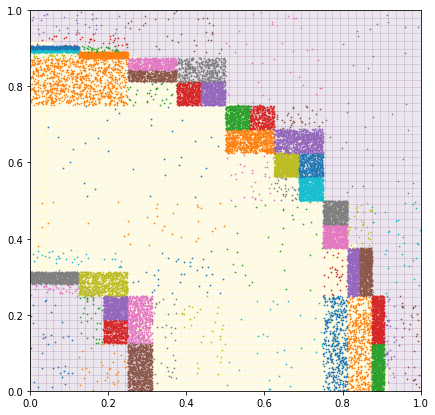

In [733]:
miser_params = {
    "MNBS": 32*16*2,
    "MNPTS": 16*2,
    "pfac": 0.1,
    "alpha": 2,
}

miser = MISER(miser_params)

ave, var = miser.integrate(h, 50000, np.array([0., 0.]), np.array([1., 1.]))
print(ave, np.sqrt(var))

plt.figure(figsize=(7, 7))
xx, yy = np.meshgrid(np.linspace(0,1), np.linspace(0,1))
plt.pcolor(np.linspace(0,1), np.linspace(0,1), h(np.array([xx,yy])),alpha=0.1)

for pts in POINTS:
    plt.scatter(pts[0], pts[1],s=0.5)
    
plt.xlim([0,1])
plt.ylim([0,1]);